# Projet Série Temporelles
*AHOUMENOU Onel, DEVIGNAC Vladimir, DURAND Arnaud*

## Packages

In [1]:
# Cette commande permet d'installer scikit-learn.
# Après l'installation, il faut la mettre en commentaire et redemarrer le noyau
# !pip install scikit-learn

# Packages généraux (tableaux, importation et visualisation des données)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Fonctions pour la standardisation, le rmse/mse et la regression linéaire
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

# Fonctions pour la visualisation de l'autocorrelation et l'autocorrelation partielle
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Fonctions pour le test de stationnarité
from statsmodels.tsa.stattools import adfuller

# Modèle ARIMA
from statsmodels.tsa.arima.model import ARIMA

## Introduction

Dans ce projet, nous allons illustrer sur un jeu de données concret les méthodes étudiées au cours. Nos données proviennent du site kaggle https://www.kaggle.com/datasets/aminesnoussi/air-pollution-dataset. Il traite de la pollution de l'air à Pekin entre le 01 Janvier 2010 et le 31 Décembre 2014.

  L'objectif est donc de prédire la pollution futur à l'aide des données passées en suivant le plan suivant:

1. [Pré-traitement des données](#partie1)
2. [Gestion de la non-stationnarité](#partie2)
3. [Identification du modèle probabiliste](#partie3)
4. [Estimation des paramètres du modèle](#partie4)
5. [Prédiction des valeurs futures](#partie5)
6. [Evaluation de la précision de prédiction](#partie6)

## Pré-traitement des données <a id="partie1"></a>

### Analyse de la base de données

    

In [2]:
# Importation des données

data = pd.read_csv("air_pollution.csv", index_col='date', parse_dates=True)
data.head()

,pollution_today,dew,temp,press,wnd_spd,snow,rain,pollution_yesterday
date,,,,,,,,
2010-01-02,145.958333,-8.500000,-5.125000,1024.750000,24.860000,0.708333,0.0,10.041667
2010-01-03,78.833333,-10.125000,-8.541667,1022.791667,70.937917,14.166667,0.0,145.958333
2010-01-04,31.333333,-20.875000,-11.500000,1029.291667,111.160833,0.000000,0.0,78.833333
2010-01-05,42.458333,-24.583333,-14.458333,1033.625000,56.920000,0.000000,0.0,31.333333
2010-01-06,56.416667,-23.708333,-12.541667,1033.750000,18.511667,0.000000,0.0,42.458333


### Isolation de la variable cible "pollution_today"

In [3]:
pollution = data['pollution_today']

In [4]:
# Nombre de valeurs manquantes

pollution.isna().sum()

0

Il n'y a aucune valeur manquante.

In [5]:
#  Quelques statistiques utiles

pollution.describe()

count    1825.000000
mean       98.245080
std        76.807697
min         3.166667
25%        42.333333
50%        79.166667
75%       131.166667
max       541.895833
Name: pollution_today, dtype: float64

### Affichage de la série temporelle

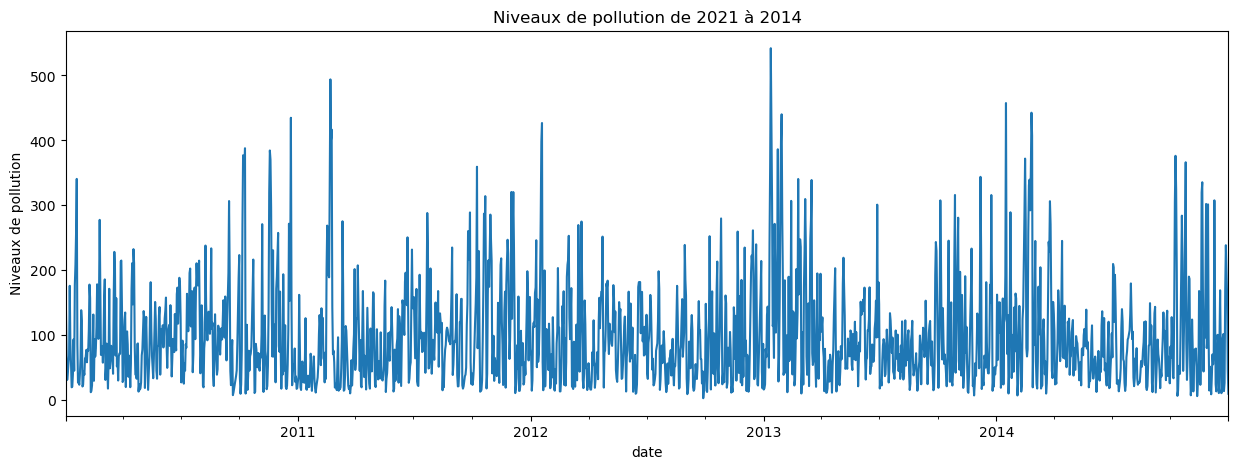

In [6]:
plt.figure(figsize=(15, 5))
pollution.plot()
plt.ylabel("Niveaux de pollution")
plt.title("Niveaux de pollution de 2021 à 2014")
plt.show()

Afin de faciliter nos analyses tout en gardant une quantité de données satisfaisante, nous allons travailler sur des moyennes de 5 jours

In [7]:
# Rééchantillonage sur 5 jours
y = pollution.resample('5D').mean()

#### Séparation entrainement - test des données

Nous allons entrainer le(s) futur(s) modèle(s) sur les données de 2010 à 2013 inclus et procéder à l'évalution du(des) dit(s) modèle(s) sur les données de 2014.

In [8]:
# Données d'entrainement
X_train = y['2010':'2013'].index
y_train = np.array(y['2010':'2013'])

# Données de test
X_test = y['2014':].index
y_test = np.array(y['2014':])

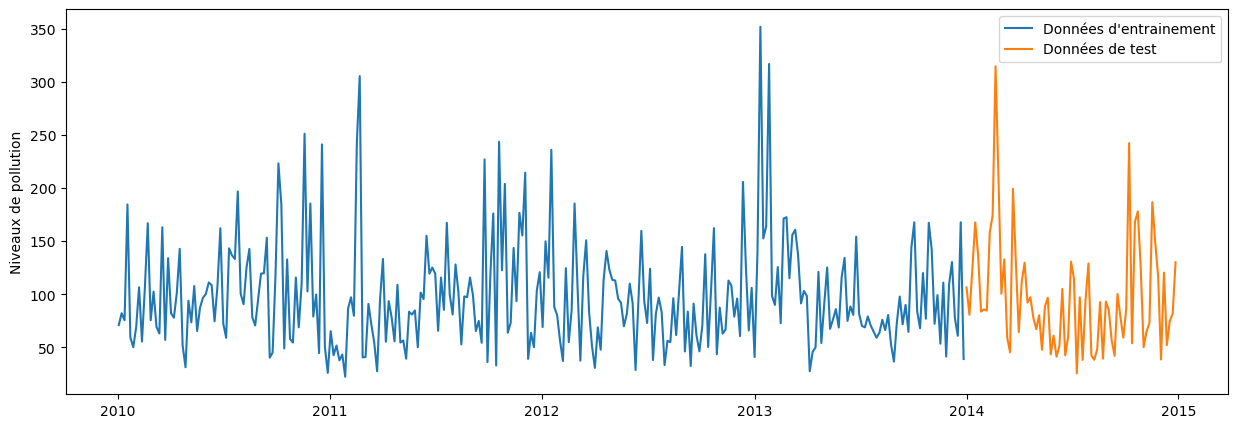

In [9]:
plt.figure(figsize=(15, 5))
plt.plot(X_train, y_train, label="Données d'entrainement")
plt.plot(X_test, y_test, label="Données de test")
plt.ylabel("Niveaux de pollution")
plt.legend()
plt.show()

#### Affichage de la série par années

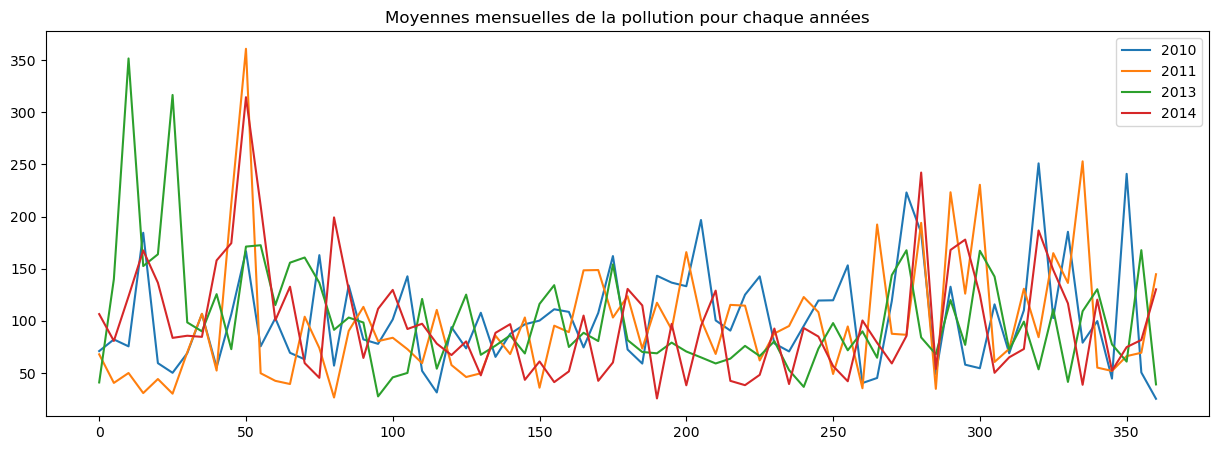

In [10]:
mois = ['Janvier', 'Février', 'Mars', 'Avril', 'Mai', 'Juin', 'Juillet', 'Aout', 'Septembre', 'Octobre', 'Novembre', 'Décembre']
années = ['2010', '2011', '2013', '2014']
x = [5*i for i in range(len(y)//5)]

plt.figure(figsize=(15, 5))
for an in années:
    plt.plot(x, pollution[an].resample('5D').mean(), label=an)
plt.legend()
plt.title("Moyennes mensuelles de la pollution pour chaque années")
plt.show()

La visualisation du graphe précendant étant difficile, nous allons le reprendre en faisant cette fois ci des moyennes mensuelles.

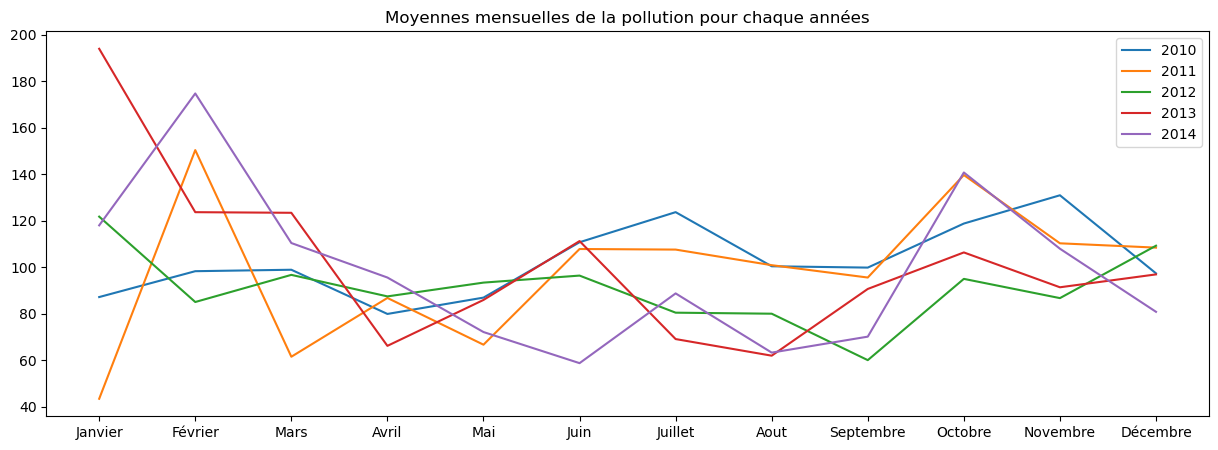

In [11]:
mois = ['Janvier', 'Février', 'Mars', 'Avril', 'Mai', 'Juin', 'Juillet', 'Aout', 'Septembre', 'Octobre', 'Novembre', 'Décembre']
années = ['2010', '2011', '2012', '2013', '2014']

plt.figure(figsize=(15, 5))
for an in années:
    plt.plot(mois, pollution[an].resample('M').mean(), label=an)
plt.legend()
plt.title("Moyennes mensuelles de la pollution pour chaque années")
plt.show()

**Par analyse visuelle du graphe précédent on fait l'hypothèse de la présence d'une saisonnalité annuelle.**

## Gestion de la non-stationnarité <a id="partie2"></a>

Nous allons donc uniquement utiliser à partir d'ici les données d'entrainement X_train et y_train.

### Estimation de la saisonnalité

Nous allons eliminer la saisonnalité à l'aide d'une moyenne mobile d'ordre 73 (5*73 = 365 pour 365 jours par an)

In [12]:
def moving_average(x, p):
    x.shape = len(x)
    return np.convolve(x, np.ones(p), "valid") / p # retourne 

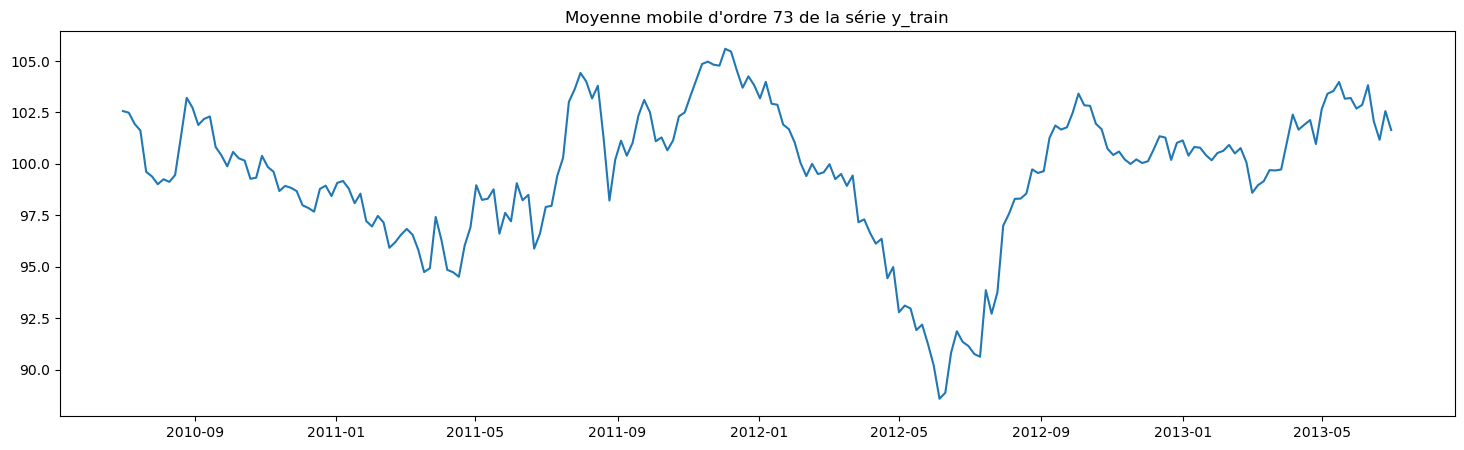

In [13]:
p = 73  # période de la moyenne mobile

y_train_sans_saison = moving_average(y_train, 73)
# x_train_sans_saison = X_train[0:len(y_train_sans_saison)]

plt.figure(figsize=(18, 5))
plt.plot(X_train[(p-1)//2 : -(p-1)//2],y_train_sans_saison)
plt.title("Moyenne mobile d'ordre 73 de la série y_train")
plt.show()

Nous allons determiner les coefficients de saisonnalité centrés.

In [14]:
# On retire aux valeurs de bases les valeurs dénuées de saisonnalités
serie_corrigee = y_train[(p-1)//2:-(p-1)//2] - y_train_sans_saison

# On calcule les coefficients de saisonnalité en faisant des moyennes 
# de chaque valeurs dont l'index est congru à i modulo p = 73 pour  i dans [0; 72]
saisonnalite = [np.mean([serie_corrigee[j] for j in range(0, len(y_train_sans_saison)) if j%p == i]) for i in range(p)]

# On centre les valeurs obtenues
moy = np.mean(saisonnalite)
for i in range(len(saisonnalite)):
    saisonnalite[i] = saisonnalite[i] - moy

saison = [saisonnalite[i%73] for i in range(len(y_train))]

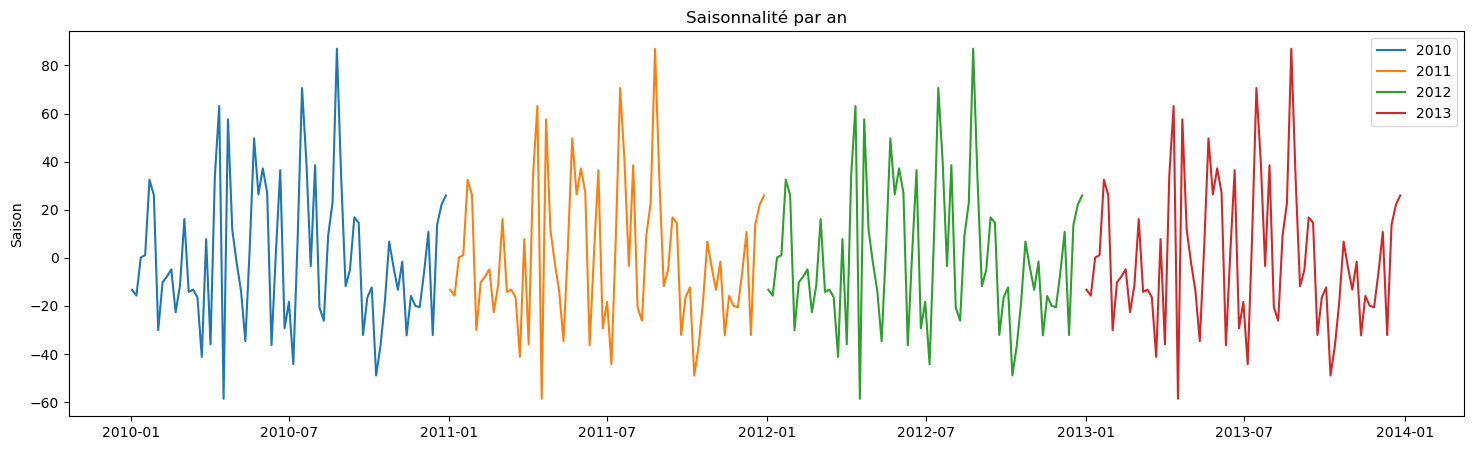

In [15]:
# Visualisation

plt.figure(figsize=(18,5))
for i in range(4): # 4 pour 4 années
    plt.plot(X_train[73*i:73*(i+1)],saison[73*i:73*(i+1)], label=années[i])
plt.legend()
plt.ylabel("Saison")
plt.title("Saisonnalité par an")
plt.show()

### Estimation de la tendance

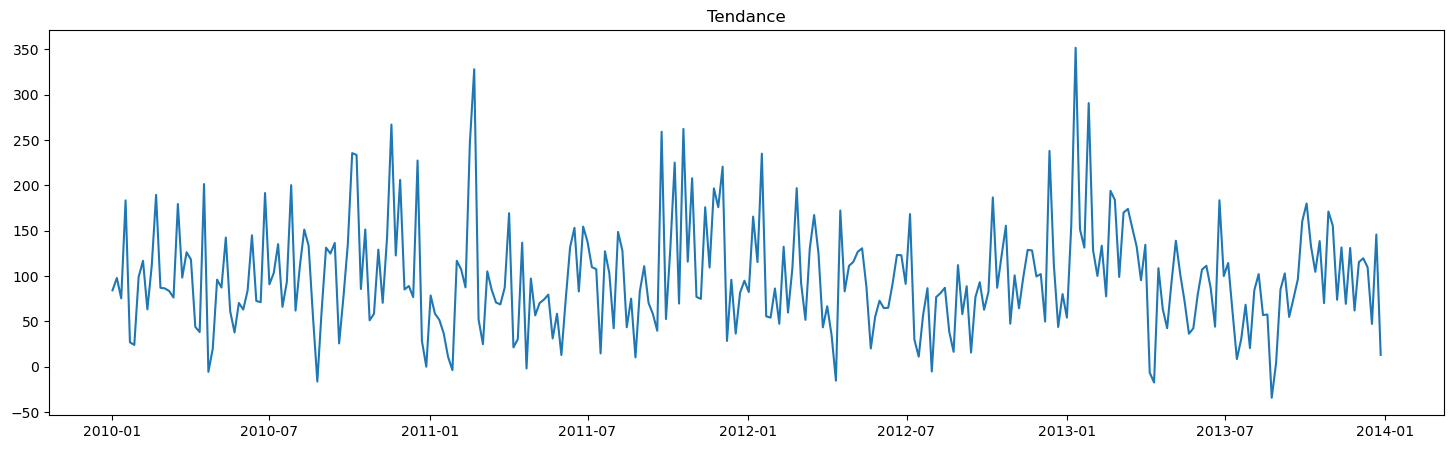

In [16]:
# On retire aux données de bases la saisonnalité
tendance = y_train - saison

# Visualisation
plt.figure(figsize=(18, 5))
plt.plot(X_train, tendance)
plt.title("Tendance")
plt.show()

### Modelisation de la tendance

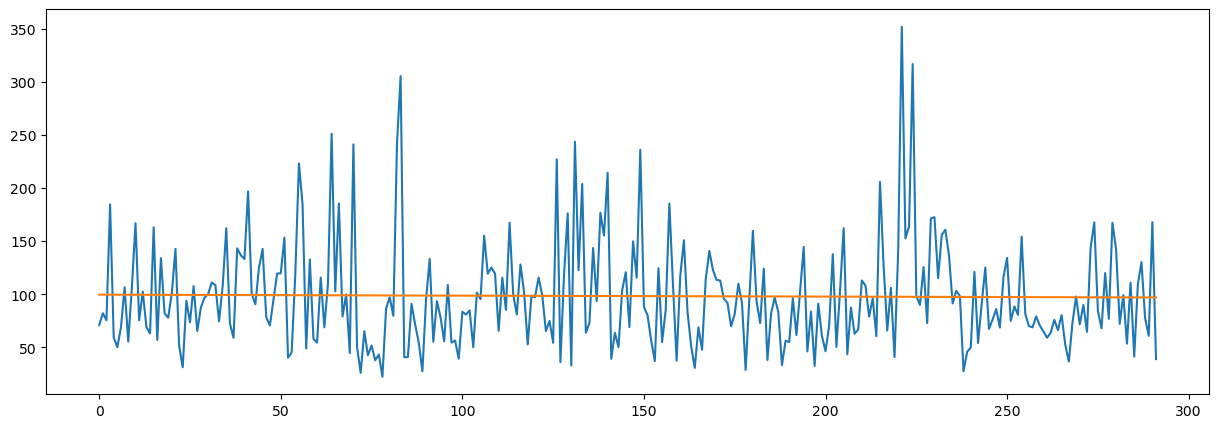

In [17]:
# On remplace les dates par le temps t allant de 0 à T, avec t dans l'ensemble des nombres naturels
Xt_train = np.array([i for i in range(len(y_train))])

# On procède à un changement de dimension demandé par Python pour la régression
Xt_train.shape = (len(Xt_train), 1) 

modele_tendance = LinearRegression().fit(Xt_train, tendance)
fitted_values = modele_tendance.predict(Xt_train)

plt.figure(figsize=(15,5))
plt.plot(y_train)
plt.plot(fitted_values)
plt.show()

### Calcul et standartisation des résidus

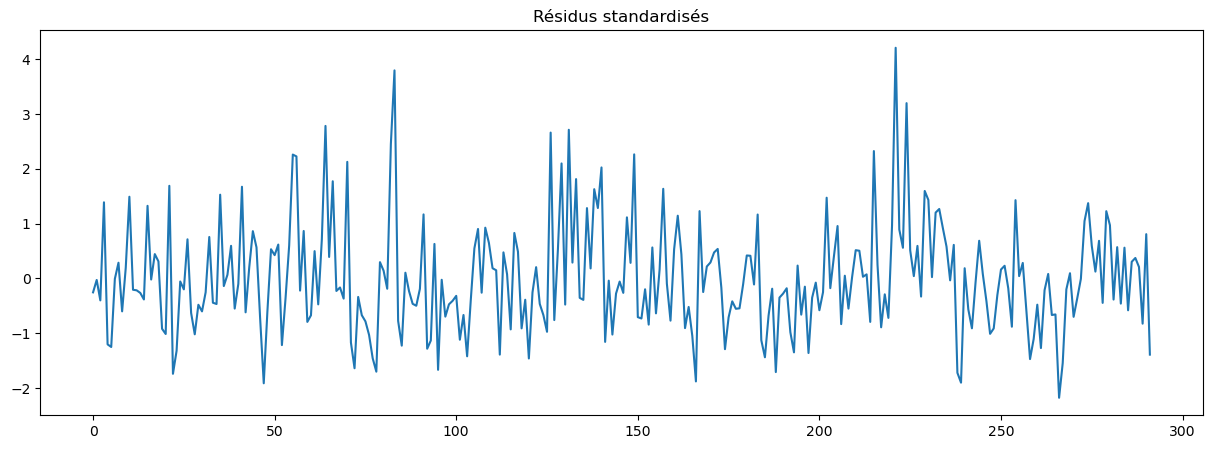

In [18]:
# On calcul les résidus en retirant des données la tendance modélisée et la saisonnalité
residus = y_train - fitted_values - saison
residus.shape = (len(residus), 1)           # Même changement de dimension que précédemment

# Standartisation des résidus: on retire la moyenne et divise par la variance
residus_standards = StandardScaler().fit_transform(residus)

# Visualisation
plt.figure(figsize=(15,5))
plt.plot(residus_standards)
plt.title("Résidus standardisés")
plt.show()

### Test de stationnarité: test de Dickey-Fuller
L'hypothèse nulle de ce test est que la série n'est pas stationnaire.

On rentre les données et le type de régréssion: ici "n" signifie que l'on ni saisons, ni tendance.

In [19]:
adfuller(residus_standards, regression="n")

(-7.668757355893759,
 1.866957056091453e-12,
 2,
 289,
 {'1%': -2.5735197583841187,
  '5%': -1.9419684074895862,
  '10%': -1.6159324128697468},
 778.129939788668)

#### Inteprétation des résulats :

Les valeurs obtenus représentent (dans l'ordre):

 * La statistique de test

 * La P-valeur du test

 * Le nombre de lag utilisés

 * Le nombre de valeurs utilisés

 * La valeur critique du test pour les niveaux 1%, 5% et 10%

 * La valeur de l'AIC

La P-valeur du test $1.8669*10^-12$ étant inférieur à $0.05$ et la statistique de test $-7,6687$ étant inférieur à la valeur au seuil critique à 1% $-2,5735$, on rejete l'hypothèse de non stationnarité avec une précision de 1%.

La série obtenue est donc bien stationnaire.

## Identification du modèle probabiliste <a id=partie3></a>

### Analyse de l'auto correlation

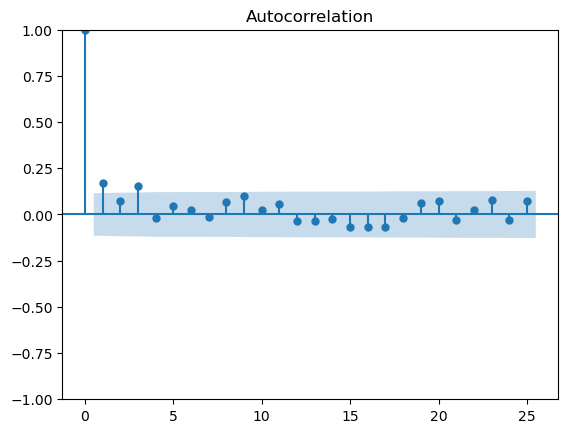

In [20]:
plot_acf(residus_standards)
plt.show()

On observe qu'un modèle MA(3) serait adapté à nos données

### Analyse de l'auto correlation partielle

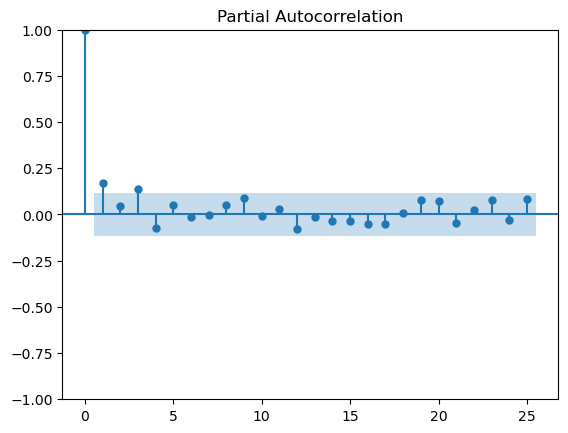

In [21]:
plot_pacf(residus_standards, method='ywm')
plt.show()

On observe qu'un modèle AR(3) serait adapté à nos données

**Nous décidons donc de choisir pour modèle probabiliste le modèle ARMA(3,3).**

En plus nous étudierons un modèle proche tel que le modèle **ARMA(2,2)**.

## Estimation des paramètres des modèles <a id=partie4></a>

### Modèle ARMA(3, 3)

In [22]:
modele_arma_33 = ARIMA(residus_standards, order=(3, 0, 3)).fit()
modele_arma_33.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  292
Model:                 ARIMA(3, 0, 3)   Log Likelihood                -405.656
Date:                Thu, 19 Dec 2024   AIC                            827.312
Time:                        15:32:00   BIC                            856.726
Sample:                             0   HQIC                           839.094
                                - 292                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0027      0.092     -0.030      0.976      -0.183       0.178
ar.L1         -0.5391      0.290     -1.856      0.063      -1.108       0.030
ar.L2         -0.0805      0.370     -0.218      0.828      -0.806       0.645
ar.L3          0.3654      0.270      1.353      0.176      -0.164       0.895
ma.L1          0.7060      0.296      2.388      0.017       0.126       1.286
ma.L2          0.2275      0.406      0.560      0.575      -0.568       1.023
ma.L3         -0.1658      0.308     -0.538      0.590      -0.769       0.438
sigma2         0.9419      0.070     13.386      0.000       0.804       1.080
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                49.33
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                             0.80
Prob(H) (two-sided):                  0.19   Kurtosis:                         4.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Modèle ARMA(2, 2)

In [23]:
modele_arma_22 = ARIMA(residus_standards, order=(2, 0, 2)).fit()
modele_arma_22.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  292
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -406.075
Date:                Thu, 19 Dec 2024   AIC                            824.149
Time:                        15:32:00   BIC                            846.210
Sample:                             0   HQIC                           832.986
                                - 292                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0037      0.099     -0.038      0.970      -0.197       0.189
ar.L1         -0.0332      0.235     -0.141      0.888      -0.493       0.427
ar.L2          0.6320      0.148      4.263      0.000       0.341       0.923
ma.L1          0.2224      0.237      0.937      0.349      -0.243       0.688
ma.L2         -0.6099      0.186     -3.273      0.001      -0.975      -0.245
sigma2         0.9445      0.068     13.819      0.000       0.811       1.078
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                54.89
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                             0.81
Prob(H) (two-sided):                  0.22   Kurtosis:                         4.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Prédiction des valeurs futures <a id=partie5></a>

In [24]:
def prediction(modele_arma, modele_tendance, saisonnalite, y_train, y_test):
    # On remplace les dates par le temps t allant de 0 à T, avec t dans l'ensemble des nombres naturels
    Xt_test = np.array([i+len(y_train) for i in range(len(y_test))])
    Xt_test.shape = (len(y_test), 1)
    
    # Tendance prédicte
    t_pred = modele_tendance.predict(Xt_test)
    
    # Résidus prédits
    r_pred = modele_arma.get_forecast(steps=len(y_test)).predicted_mean
    
    # Prédiction
    valeurs_predites = t_pred + saisonnalite + r_pred
    
    return valeurs_predites
    
def affichage(valeurs_predites, X_train, X_test, y_train, y_test):
    prediction = pd.Series(valeurs_predites, index=X_test)
    
    # Visualisation des données d'entrainement, de test et prédites
    plt.figure(figsize=(15,5))
    plt.plot(X_train,y_train, label="Données d'entrainement")
    plt.plot(X_test,y_test, label='Données Test', color='orange')
    plt.plot(prediction, label='Données prédites', color='green')
    plt.title('Prédiction du modèle')
    plt.xlabel('Date')
    plt.ylabel('Taux de pollution')
    plt.legend()
    plt.show()

### Modèle ARMA(3, 3)

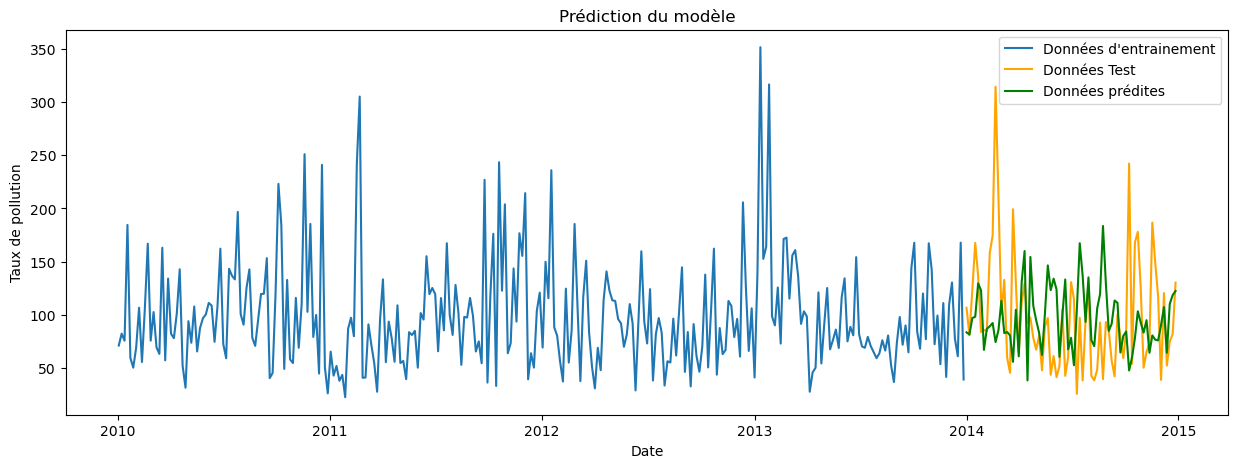

In [25]:
prediction_arma_33 = prediction(modele_arma_33, modele_tendance, saisonnalite, y_train, y_test)
affichage(prediction_arma_33, X_train, X_test, y_train, y_test)

### Modèle ARMA(2, 2)

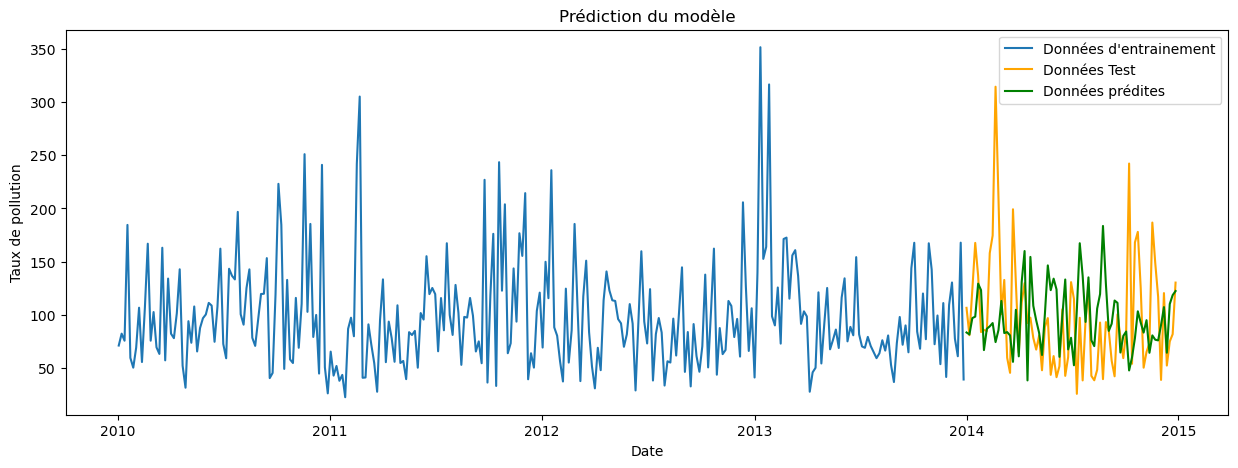

In [26]:
prediction_arma_22 = prediction(modele_arma_22, modele_tendance, saisonnalite, y_train, y_test)
affichage(prediction_arma_22, X_train, X_test, y_train, y_test)

## Evaluation de la précision de prédiction <a id=partie6></a>

Une première comparaison de nos modèles grace au critère d'Akaike (AIC) nous dits que le modèle **ARMA(2, 2)** (AIC = 824,149) est meilleur de peu que le modèle **ARMA(3, 3)** (AIC = 827,312).

Nous allons re-évaluer les performances de nos modèles grace au critère RMSE.

In [27]:
def evaluation(y_test, prediction):
    mse = mean_squared_error(y_test, prediction)
    rmse = mse**0.5
    print('RMSE:', rmse)

### Modèle ARMA(3, 3)

In [28]:
evaluation(y_test, prediction_arma_33)

RMSE: 63.99525098324269


### Modèle ARMA(2, 2)

In [29]:
evaluation(y_test, prediction_arma_22)

RMSE: 63.99789411621394


Le modèle **ARMA(3, 3)** se révèle etre le meilleur de peu selon le critère RMSE.

**Conclusion:** Les deux modèles sont équivalents